### Загрузка пакетов

In [2]:
import pandas as pd
import numpy as np
#import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode, iplot

#init_notebook_mode(connected=True)
%matplotlib inline

# Задание 1

#### В предоставленном датасете проанализировать несколько характеристик и построить набор визуализаций

###### _Функции_

In [3]:
# Скачаем все csv файлы и объединим их
def DownloadCSVTables(url, start, end):
    ""
    # Пустая таблица для последующей конкатенации
    table = pd.DataFrame(columns=['Name', 'Gender', 'Count'])

    # Года записей в таблице
    years = [year for year in range(start, end+1)]    

    # Получим каждую таблицу и добавим в общий DataFrame
    for year in years:
        table_ = pd.read_csv(url + str(year) + '.txt', names=['Name', 'Gender', 'Count'])
        table_['Year'] = str(year)
        
        table = pd.concat([table_, table], sort=False)
        
    return table


# # # # # # # # # # # # # # # # 
#  Функции отрисовки графиков #
# # # # # # # # # # # # # # # # 

# Lineplot с факторизацией и без
def plot_dynamic(x, y, y_lab='', x_lab='', hue=None, linewidth=0.65, color=None, data=None, size=None):
    # Setting fig
    sns.set(rc={'figure.figsize':(15,9)})
    plt.style.use('ggplot')
    
    # Drawning
    gp = sns.lineplot(x=x, y=y, hue=hue, data=data, linewidth=linewidth)

    # Setting plot
    gp.set(ylabel=y_lab, xlabel=x_lab)

    return gp

###### Загрузка данных

In [11]:
# Загрузка данных из сети
#data = DownloadCSVTables(url='https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/datasets/babynames/yob', start=1880, end=2010)
#data.to_csv('babynames.csv', index=False)

# Загрузка данных из файла
data = pd.read_csv('babynames.csv')

# head
data.head()

,Name,Gender,Count,Year
0,Isabella,F,22731,2010
1,Sophia,F,20477,2010
2,Emma,F,17179,2010
3,Olivia,F,16860,2010
4,Ava,F,15300,2010


In [13]:
data = data.astype({'Count':'int32'})

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690784 entries, 0 to 1690783
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Name    1690784 non-null  object
 1   Gender  1690784 non-null  object
 2   Count   1690784 non-null  int32 
 3   Year    1690784 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 45.1+ MB


###### Преобразование данных

In [12]:
# Заменим Year на полноценную дату
data['Year'] = data['Year'].map(lambda x: str(x)+ '-01-01')

# Преобразуем типы данные в корректные
data = data.astype({'Year':'datetime64[ns]', 'Count':'int64', 'Gender':'category', 'Name':'str'})

In [13]:
# Проверим изменения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690784 entries, 0 to 1690783
Data columns (total 5 columns):
Unnamed: 0    1690784 non-null int64
Name          1690784 non-null object
Gender        1690784 non-null category
Count         1690784 non-null int64
Year          1690784 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 53.2+ MB


###### Сгруппируйте данные по полу и визуализируйте общую динамику рождаемости обоих полов

In [14]:
# Сгруппируем данные по полу и возрасту
data_group_gender_year = data.groupby(['Gender', 'Year']).agg({'Count':sum}).reset_index()
data_group_gender_year.head()

,Gender,Year,Count
0,F,1880-01-01,90993
1,F,1881-01-01,91955
2,F,1882-01-01,107851
3,F,1883-01-01,112322
4,F,1884-01-01,129021


D:\Programs\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


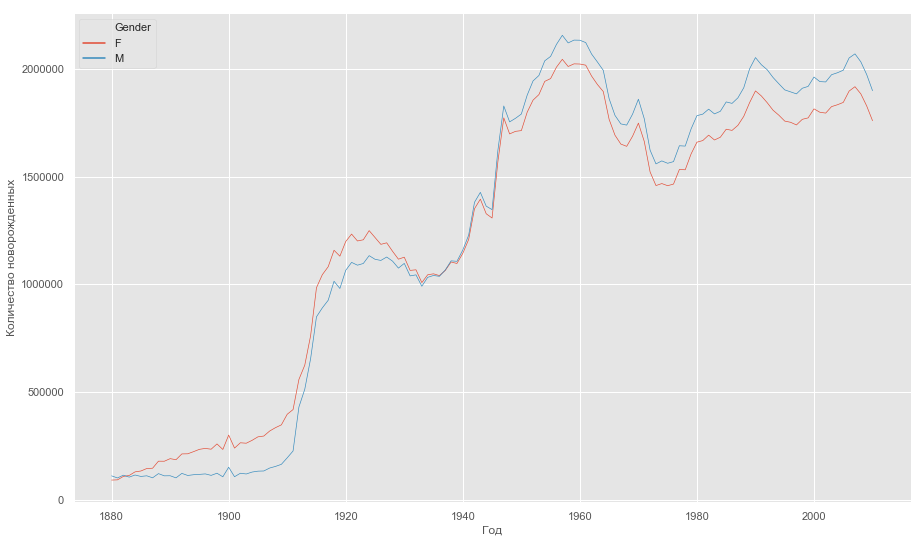

In [15]:
# Нарисуем
plot_dynamic(data=data_group_gender_year, x="Year", y="Count", hue="Gender", y_lab='Количество новорожденных', x_lab='Год')

###### Найдите самые популярные имена за всю историю

In [16]:
# Сгруппируем данные по именам и полу
data_group_name_gender = data.groupby(['Gender', 'Name']).agg({'Count':sum})
data_group_name_gender = data_group_name_gender.groupby(['Gender']).apply(lambda x: x.sort_values(["Count"], ascending = False))

In [17]:
# Самые популярные женские и мужские имена в истории
pd.concat([data_group_name_gender.loc['F'].iloc[0:5, :], data_group_name_gender.loc['M'].iloc[0:5, :]])

Count
Gender Name              
F      Mary       4103935
       Patricia   1568742
       Elizabeth  1561874
       Jennifer   1455078
       Linda      1448771
M      James      5049727
       John       5040319
       Robert     4767995
       Michael    4243903
       William    3986586

###### Разбейте весь временной промежуток в данных на 10 частей и для каждой найдите самое популярное имя каждого пола. Для каждого найденного имени визуализируйте его динамику за все время

In [18]:
# Создадим копию data
data_name_index = data.copy()

# Проиндексироуем данные
data_name_index.index = pd.DatetimeIndex(list(data_name_index['Year']))
data_name_index = data_name_index[['Name', 'Gender', 'Count']]

In [19]:
# Зададим количество интервалов
part = 10
period = round(len(data['Year'].unique()) / part)

# Разделим на ~ 10 частей
# Найдем самое часто встречающееся имя с группировкой по полу
data_name_gender_argmax = data_name_index.resample(str(period) + 'A').apply(lambda x: x[['Name', 'Gender', 'Count']].groupby(['Name', 'Gender']).agg({'Count':sum}).groupby(['Gender']).agg({'Count': lambda x: x.idxmax()}))

# Вытащим только имя
data_name_gender_argmax.applymap(lambda x: x[0])

Count
           Gender          
1880-12-31 F           Mary
           M           John
1893-12-31 F           Mary
           M           John
1906-12-31 F           Mary
           M           John
1919-12-31 F           Mary
           M           John
1932-12-31 F           Mary
           M         Robert
1945-12-31 F           Mary
           M          James
1958-12-31 F          Linda
           M          James
1971-12-31 F           Lisa
           M        Michael
1984-12-31 F       Jennifer
           M        Michael
1997-12-31 F        Jessica
           M        Michael
2010-12-31 F          Emily
           M          Jacob

In [20]:
# Выберем из всего массива только самые популярные имена
uniq_names = set([i for i in data_name_gender_argmax['Count']])

# Отфильтруем по ним данные
data_argmax_name = data_name_index.copy()
data_argmax_name = data_argmax_name[data_argmax_name['Name'].isin([i[0] for i in uniq_names])].reset_index()

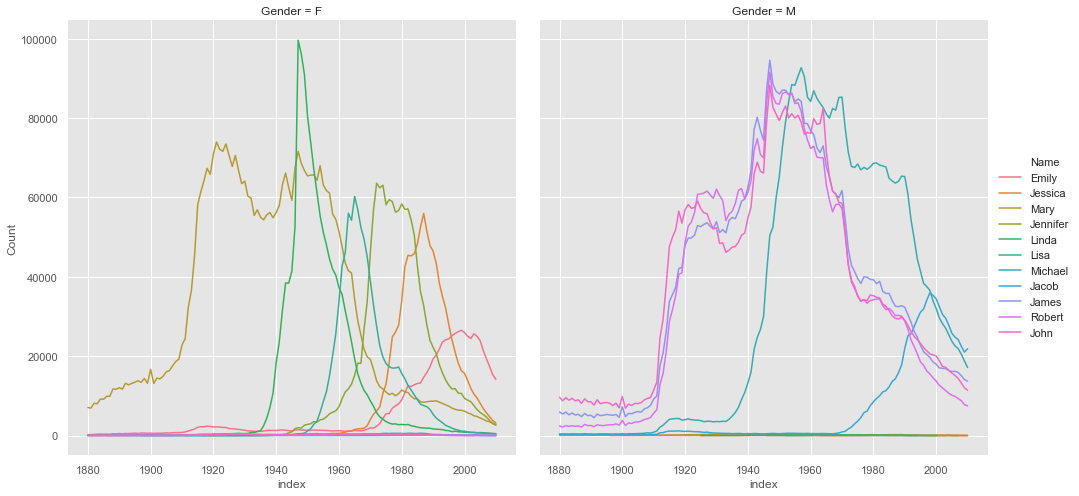

In [21]:
# Построим распределение по обоим полам 
sns.relplot(x="index", y="Count",
            hue="Name", col="Gender",
            height=7, aspect=1, facet_kws=dict(sharex=False),
            kind="line", legend="brief", data=data_argmax_name)

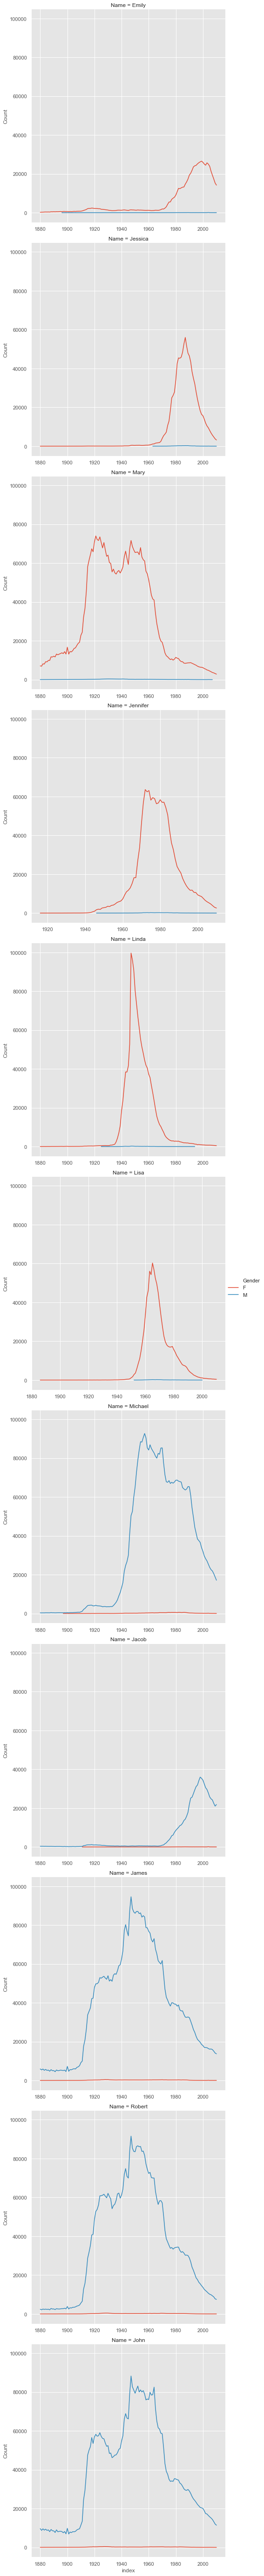

In [22]:
# Построим распределение по обоим полам 
sns.relplot(x="index", y="Count", row='Name', hue='Gender',
            height=7, aspect=1, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=data_argmax_name)

###### Для каждого года рассчитайте сколько имен покрывают 50% людей, визуализируйте

<h5 style="color:red"> Исправление </h5>

In [23]:
# Для начала посчитаем количество пользователей за каждый год и поделим на 2, чтобы понять сколько человек нужно отсечь
data_sum_year = data[['Year', 'Count']].groupby('Year').sum() / 2

# Теперь сгруппируем данные и по каждому году посчитаем накопленную сумму (отсортироваа заранее)
data_cumsum_name = data[['Year', 'Name', 'Count']].groupby(['Year', 'Name']).sum().groupby(level=0, as_index=False).apply(lambda x: x.sort_values(['Count']).cumsum()).reset_index()

# Объединим и отрежем лишнее
data_median_name = data_cumsum_name.merge(data_sum_year, how='left', suffixes=('','_median'), on='Year')
data_median_name = data_median_name[data_median_name['Count'] > data_median_name['Count_median']]
data_name = data_median_name

# Посчитаем количество имен
data_median_name = data_median_name[['Year', 'Name']].groupby('Year').nunique()
data_median_name = data_median_name.drop('Year', axis=1).reset_index()

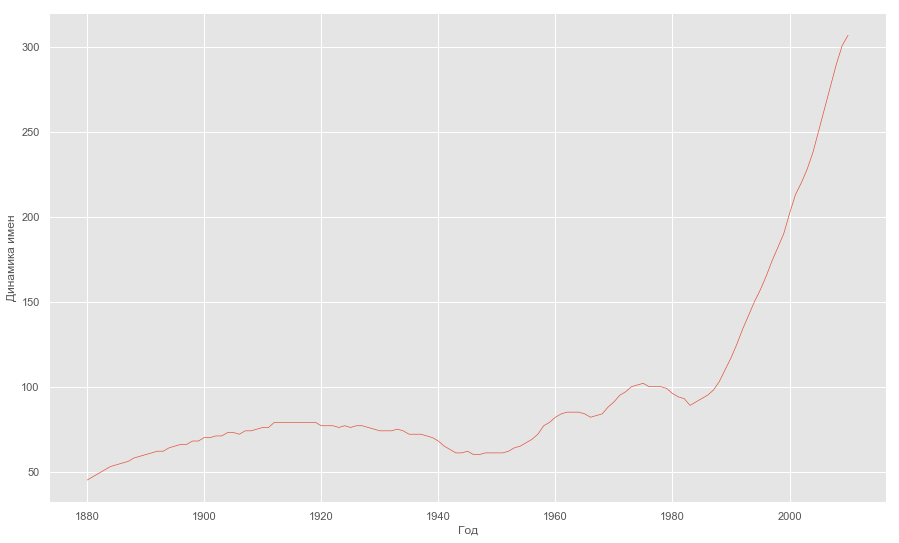

In [24]:
# Нарисуем
plot_dynamic(data=data_median_name, x="Year", y="Name", y_lab='Динамика имен', x_lab='Год')

###### Составьте список из нескольких известных людей и оцените их влияние на динамику имен, постройте наглядную визуализацию

###### Функции 

In [106]:
def color(num):
    if num == 1:
        return 'red'
    elif num == 2:
        return 'black'
    else:
        return 'green'

In [111]:
# Сгруппируем число новорожденных по именам
data_name = data.groupby(['Year', 'Name']).agg({'Count':sum})
data_name = data_name.reset_index()

# Выберем 3-5 самых популярных имени за каждый год
num_name = 5
data_name['Place'] = 1
data_name          = data_name.groupby('Year').apply(lambda x: x.sort_values(['Count'], ascending=False).iloc[0:num_name][['Year', 'Name', 'Count', 'Place']])
data_name['Place'] = data_name.groupby(level=0).agg({'Place':np.cumsum})['Place']
data_name.columns  = ['Years', 'Name', 'Count', 'Place']; 
data_name          = data_name.reset_index()[['Years', 'Name', 'Count', 'Place']]

Text(1910, Shirley, 'Shirley Temple - actress')

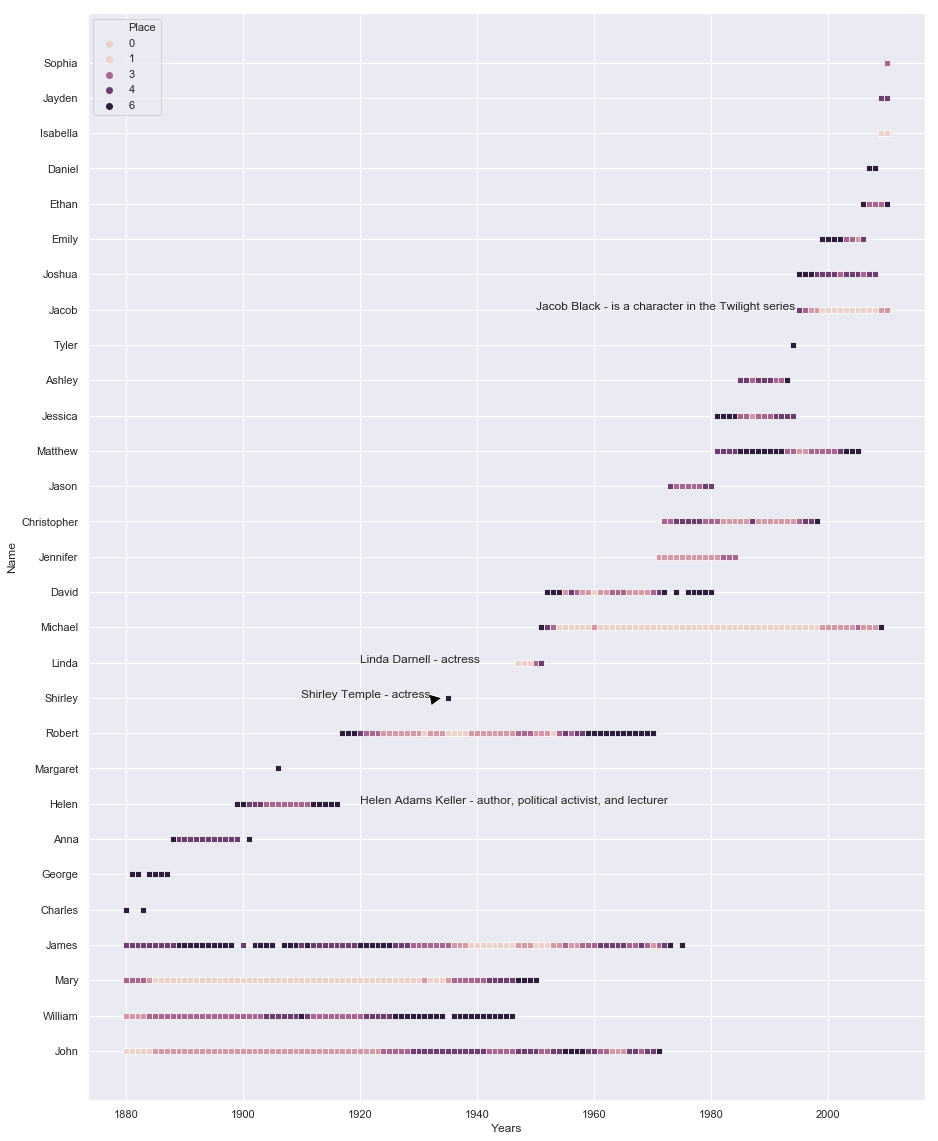

In [117]:
sns.set(rc={'figure.figsize':(15, 20)})
#plt.style.use('ggplot')

gp = sns.scatterplot(data=data_name, y='Name', x='Years', hue='Place', marker=',')

#gp.set(ylabel='Имя и популярность имени', xlabel='Год')

plt.annotate('Linda Darnell - actress', xy=(1940, 'Linda'), xytext=(1920, 'Linda'))
plt.annotate('Helen Adams Keller - author, political activist, and lecturer', xy=(1920, 'Helen'), xytext=(1920, 'Helen'))
plt.annotate('Jacob Black - is a character in the Twilight series', xy=(2000, 'Jacob'), xytext=(1950, 'Jacob'))
plt.annotate('Shirley Temple - actress', xy=(1934, 'Shirley'), xytext=(1910, 'Shirley'), arrowprops=dict(facecolor='black'))

###### Выберите 4 года из всего промежутка и отобразите для каждого года распределение по первой букве в имени, по последней букве в имени

***Функции***

In [28]:
# Выберем 4 случайных года
import random as rand

def random_year(number, list_year):
    year = list()
    for i in range(number):
        index = rand.randint(0, len(list_year))
        year.append(list_year[index])
    return year

years = random_year(4, data['Year'].unique())
years

[numpy.datetime64('1958-01-01T00:00:00.000000000'),
 numpy.datetime64('1890-01-01T00:00:00.000000000'),
 numpy.datetime64('1902-01-01T00:00:00.000000000'),
 numpy.datetime64('1952-01-01T00:00:00.000000000')]

In [29]:
# Сделаем выборку первых и последних сиволов в имени
data_word = data[data['Year'].isin(years)][['Year', 'Name']].apply(lambda x: (x['Year'], x['Name'][0], x['Name'][-1]), axis=1)
data_word = pd.DataFrame(list(data_word.map(lambda x: {'Year':x[0], 'First':x[1].lower(), 'Last':x[2].lower()})))
data_word.head()

,First,Last,Year
0,m,y,1958-01-01
1,s,n,1958-01-01
2,l,a,1958-01-01
3,k,n,1958-01-01
4,p,a,1958-01-01


In [30]:
# Сгруппируем данные
data_word_f = data_word.groupby(['Year', 'First']).agg({'First':len})
data_word_l = data_word.groupby(['Year', 'Last']).agg({'Last':len})

# Удаление мультииндекса
data_word_f.columns = ['Count']
data_word_l.columns = ['Count']
data_word_f = data_word_f.reset_index()
data_word_l = data_word_l.reset_index()

[Text(0, 0.5, 'Количество встерчаемых имен'), Text(0.5, 0, 'Год')]

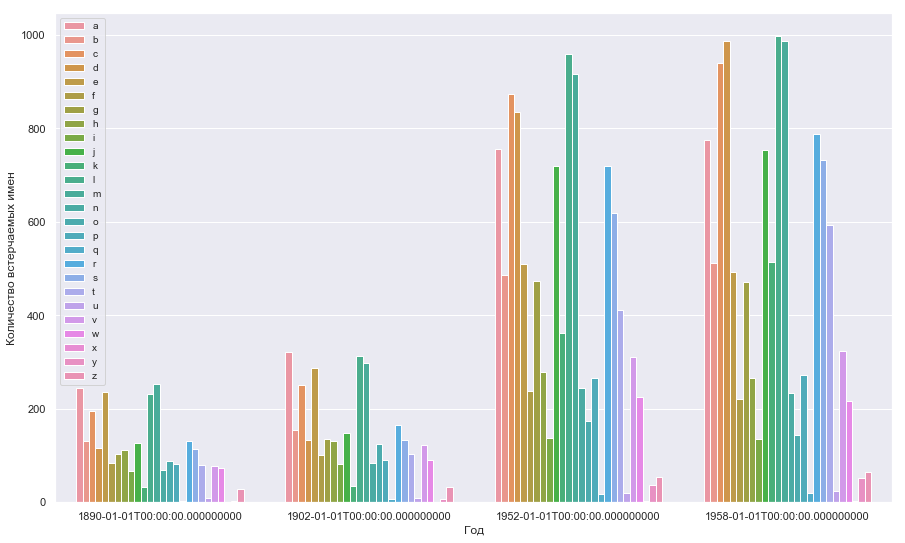

In [31]:
# Построим barchat
sns.set(rc={'figure.figsize':(15,9)})

# Построим распределение для первых букв
data_word_f_p = sns.barplot(x='Year', y='Count', hue='First', data=data_word_f) 
data_word_f_p.legend(loc='upper left', fontsize='10')
data_word_f_p.set(ylabel='Количество встерчаемых имен', xlabel='Год')

[Text(0, 0.5, 'Количество встерчаемых имен'), Text(0.5, 0, 'Год')]

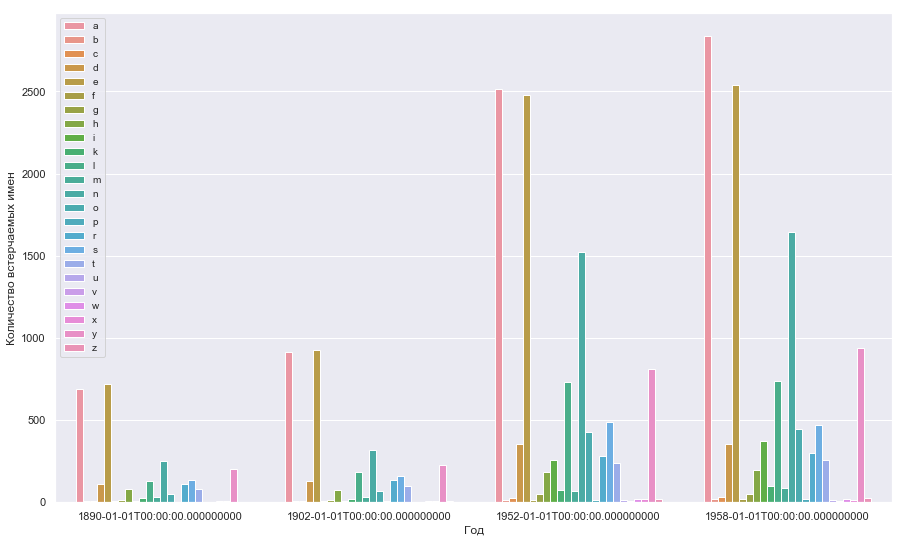

In [32]:
# Построим распределение для последних букв
data_word_l_p = sns.barplot(x='Year', y='Count', hue='Last', data=data_word_l) 
data_word_l_p.legend(loc='upper left', fontsize='10')
data_word_l_p.set(ylabel='Количество встерчаемых имен', xlabel='Год')

# Задание 2


### Выбрать датасет и провести его анализ

*Данные: https://www.kaggle.com/START-UMD/gtd*

###### Загрузка данных

In [118]:
# Загрузим данные
data = pd.read_csv('dataset_global_terrorism.csv', encoding='cp437')
data.head()

D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


###### Обработка ненайденных стран

In [119]:
# Страны для plotly
county_plotly = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')[['COUNTRY']]

# Страны из датасета
country_dataset = pd.DataFrame(data['country_txt'].unique(), columns=['COUNTRY'])

# Найдем непересечение
country_dataset = country_dataset.merge(county_plotly, how='left', indicator=True)

In [166]:
# Anti join
#country_dataset = country_dataset[country_dataset['_merge'] == 'left_only']['COUNTRY']

# Замена некоторых стран на корерктные названия
country_clear = { "Bahamas":"Bahamas, The", "Bosnia-Herzegovina": "Bosnia and Herzegovina", "Czechoslovakia": "Slovakia", "Democratic Republic of the Congo":"Congo, Democratic Republic of the", "East Germany (GDR)": "Germany", "East Timor":"Timor-Leste", "Falkland Islands":"Falkland Islands (Islas Malvinas)", "French Guiana":"French", "Gambia":"Gambia, The", "Ivory Coast":"Cote d'Ivoire", "Martinique":"French", "Myanmar": "Burma", "North Korea":"Korea, North", "North Yemen":"Yemen", "People's Republic of the Congo":"Congo, Republic of the", "Republic of the Congo":"Congo, Republic of the", "Rhodesia":"Zimbabwe", "Serbia-Montenegro":"Montenegro", "Slovak Republic":"Slovakia", "South Korea":"Korea, South", "South Vietnam":"Vietnam", "South Yemen":"Yemen", "Soviet Union":"Russia", "Vatican City":"Italy", "West Bank and Gaza Strip":"West Bank", "West Germany (FRG)":"Germany", "Yugoslavia":"Serbia", "United States":"United States of America"}
data['country_txt'] = data['country_txt'].map(lambda x: x if str(country_clear.get(x)) == 'None' else country_clear.get(x))

###### Добавление временного индекса

In [121]:
# Input: string! - 1, 01
# Output: 01, 01
def zero(st):
    assert type(st) == str

    if len(st) == 2:
        return st
    elif len(st) == 1 and st != '0':
        return '0'+str(st)
    else:
        return '01'

In [122]:
# Для начала создадим временной индекс
data['date'] = data[['iyear', 'imonth', 'iday']].apply(lambda x: str(x['iyear'])+'-'+zero(str(x['imonth']))+'-'+zero(str(x['iday'])), axis=1)
data.index = pd.DatetimeIndex(list(data['date']))

###### Добавление континентов

In [123]:
# Добавим к регионам континенты
continent = {"Central America & Caribbean":"America","North America":"America","Southeast Asia":"Asia","South America":"America","Western Europe":"Europe","Eastern Europe":"Europe","East Asia":"Asia","Sub-Saharan Africa":"Africa","Middle East & North Africa":"Arabia","Australasia & Oceania":"Australia","South Asia":"Asia","Central Asia":"Asia"}
data['continent'] = data['region_txt'].map(lambda x: x if str(continent .get(x)) == 'None' else continent .get(x))

### Зададим ряд вопросов к нашим данным

- Каково общее количество терактов за все время?
- Каково общее количество жертв за все время?
- В каких странах-регионов больше всего терактов?
- В каких странах-регионов больше всего жертв?
- Чем пользовались при совершении террактов?

Отталкиваясь от полученных результатов будем продолжать изучать наш датасет.

###### Каково общее количество терактов за все время, каково общее количество жертв за все время?

In [124]:
# Разобьем данные на года чтобы убрать шумы
events = data.resample('AS').agg({'eventid':len, 'nkill':sum})
events = pd.melt(events.reset_index(), id_vars=['index'], value_vars=['eventid', 'nkill'])

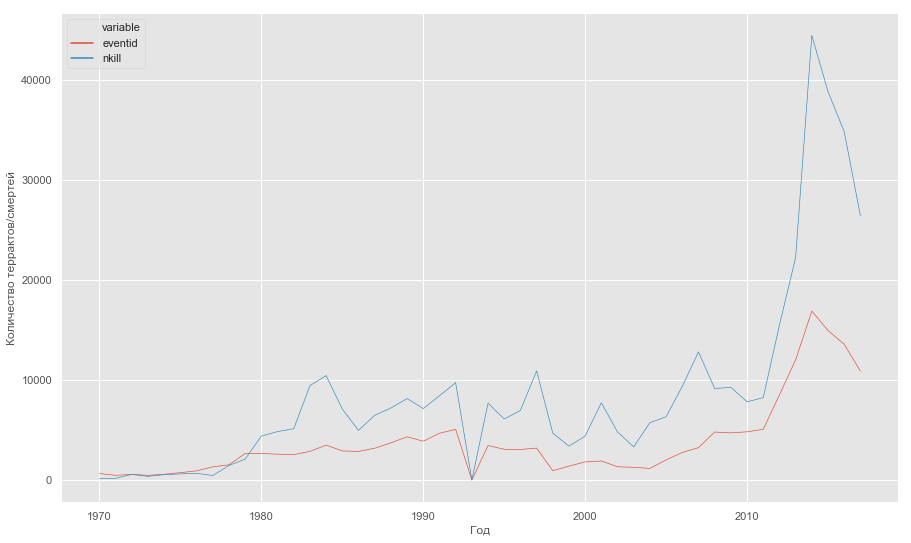

In [125]:
# Выведем динамику каоличества террактов и количества жертв
plot_dynamic(data=events, x="index", y="value", hue="variable", y_lab='Количество террактов/смертей', x_lab='Год', size='value')

*Выводы:*

- Резкий рост террористической активности с 2010-го года
- Резкое падение в середине 1990-ых (возможно неучтенные данные)
- Четкая корреляция между количеством террактов и смертей, однако замечу что с 1970-1980 годы количество смертей и количество террактов практически равно, что может говорить о различных мотивах и целях

Попробуем разделить датасет на несколько временных промежутков и посмотреть менялся ли вектор террористической активности в мире

In [126]:
# Разедедлим на 10 частей наш датасет
region_event = data[['region_txt', 'eventid']].resample('5A').apply(lambda x: x.groupby('region_txt').nunique())[['eventid']]
region_event = region_event.groupby(level=0).apply(lambda x: x.sort_values(['eventid'], ascending = False).iloc[0:5]).reset_index()
region_event['level_1'] = region_event['level_1'].map(lambda x: str(x)[0:4])
region_event.head()

,level_0,level_1,region_txt,eventid
0,1970-12-31,1970,North America,472
1,1970-12-31,1970,South America,65
2,1970-12-31,1970,Western Europe,50
3,1970-12-31,1970,Middle East & North Africa,28
4,1970-12-31,1970,Eastern Europe,12


[Text(0, 0.5, 'Регион и количество террактов'), Text(0.5, 0, 'Год')]

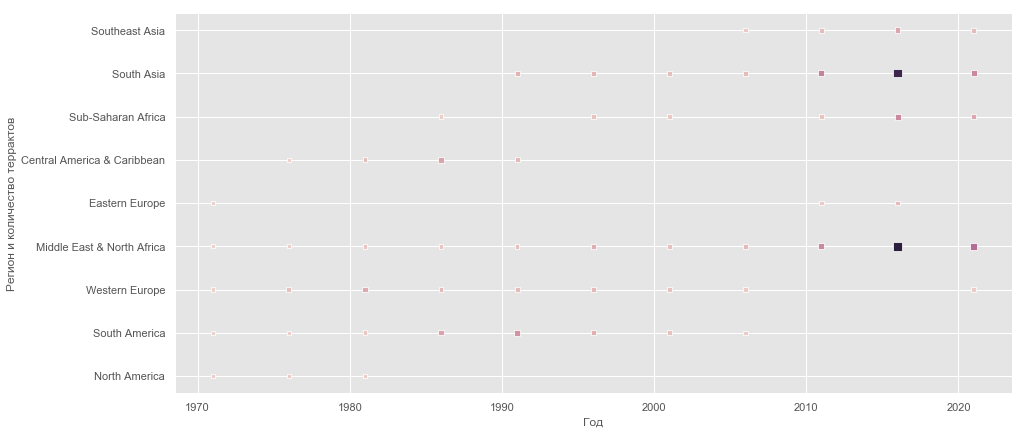

In [127]:
sns.set(rc={'figure.figsize':(15,7)})
plt.style.use('ggplot')

gp = sns.scatterplot(data=region_event, x='level_0', y='region_txt', hue='eventid', marker=',', legend=None, size='eventid')
gp.set(ylabel='Регион и количество террактов', xlabel='Год')

*Выводы:*

- Смещение активности от Американского континента и Европы (1970-2000) в Южную азию и Африку, Средний восток (2000-now)

###### Количесвто жертв по регионам

In [128]:
dead_region = data[['region_txt', 'nkill']].fillna(0).groupby('region_txt').sum()
dead_region = dead_region.reset_index()
dead_region = dead_region.sort_values(['nkill'])

[Text(0, 0.5, 'Регион'), Text(0.5, 0, 'Количество убитых')]

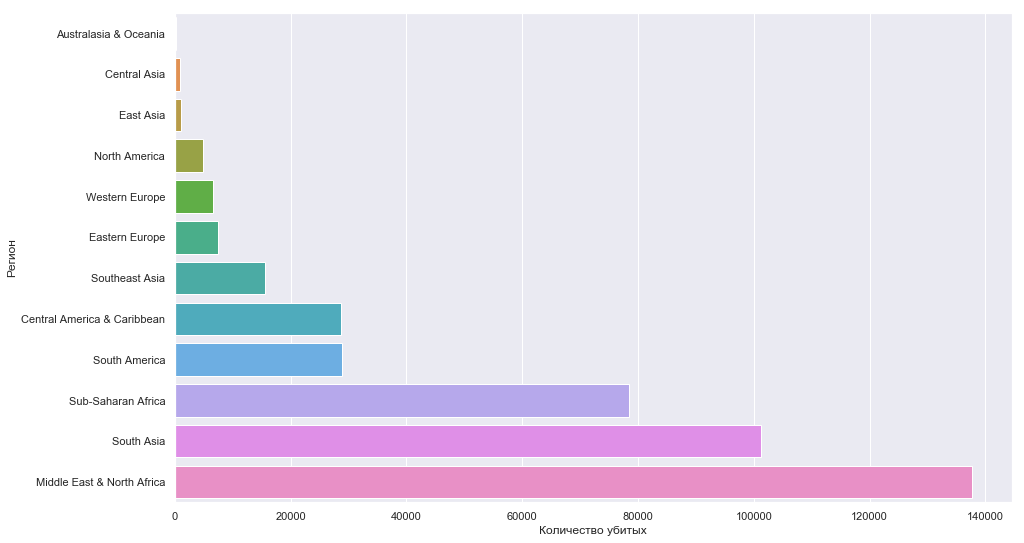

In [129]:
# Построим barchat
sns.set(rc={'figure.figsize':(15,9)})

# Построим распределение для регионов по количеству убитых за все время
gp = sns.barplot(y='region_txt', x='nkill', data=dead_region) 
gp.set(ylabel='Регион', xlabel='Количество убитых')

*Выводы:*

- Наибольшее количество жертв в Южную азии и Африке, Среднем востоке

###### В каких странах-регионов больше всего террактов?

In [169]:
# Получим данные о странах и терактах
data_country = data[['country_txt', 'eventid']]
data_country = data_country.groupby('country_txt').agg({'eventid':len})
data_country = data_country.reset_index()

In [170]:
# Создадим датасет для отображения
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

world = world.merge(data_country, left_on='name', right_on='country_txt', how='inner')

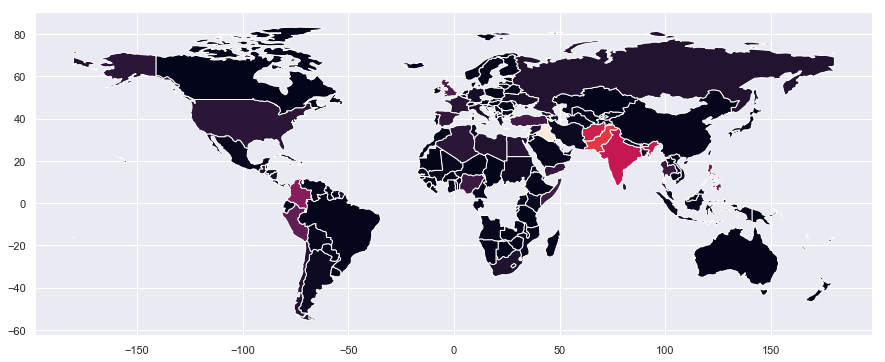

In [172]:
# Нарисуем карту
world.plot(column='eventid')

*Выводы*

- Наибольшее количество терактов было в Ираке, Пакистане и Индии
- Монголия страна с наименьшей террористической активностью

###### Тип совершения прступлений?

In [134]:
data_attacktype = data[['attacktype1_txt', 'eventid']]
data_attacktype = data_attacktype.groupby('attacktype1_txt').agg({'eventid':len})
data_attacktype = data_attacktype.reset_index()

Text(0.5, 0, 'Количество терактов')

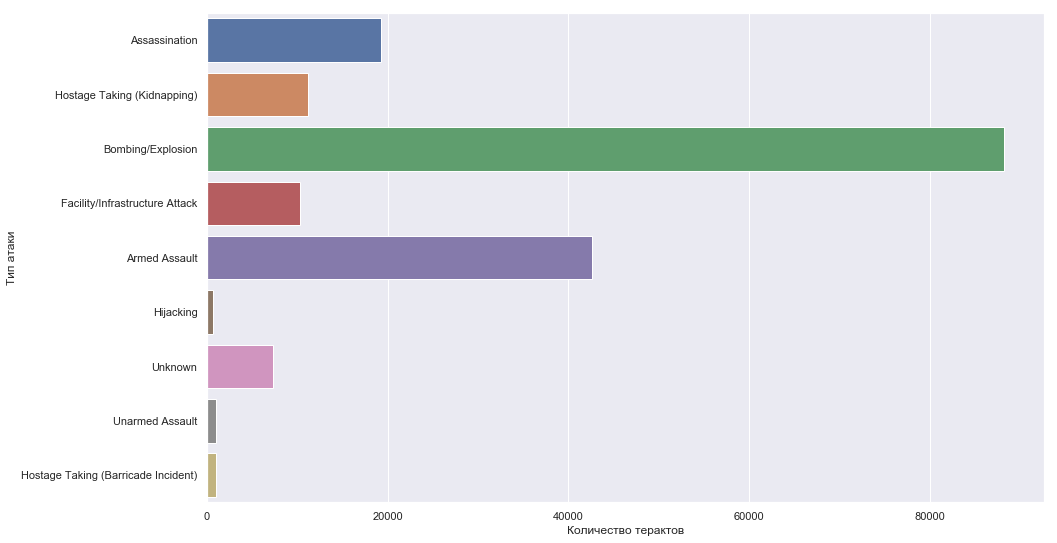

In [135]:
sns.set(rc={'figure.figsize':(15,9)})

pl = sns.countplot(y='attacktype1_txt', data=data)
pl.set_ylabel('Тип атаки')
pl.set_xlabel('Количество терактов')

###### Был ли это террорист смертник и какой тип атаки они предпочитали?

In [136]:
data_attacktype_suicide = data[['attacktype1_txt', 'suicide', 'eventid']]
data_attacktype_suicide = data_attacktype_suicide.groupby(['attacktype1_txt', 'suicide']).agg({'eventid':len})
data_attacktype_suicide = data_attacktype_suicide.reset_index()
data_attacktype_suicide = data_attacktype_suicide.merge(data_attacktype, on='attacktype1_txt')
data_attacktype_suicide['prop'] =  data_attacktype_suicide['eventid_x'] / data_attacktype_suicide['eventid_y']
data_attacktype_suicide = data_attacktype_suicide[data_attacktype_suicide['suicide'] == 1]
data_attacktype_suicide.head()

,attacktype1_txt,suicide,eventid_x,eventid_y,prop
1,Armed Assault,1,49,42669,0.001148
3,Assassination,1,262,19312,0.013567
5,Bombing/Explosion,1,6214,88255,0.070410
7,Facility/Infrastructure Attack,1,1,10356,0.000097
9,Hijacking,1,11,659,0.016692


Text(0.5, 0, 'Процент смертников')

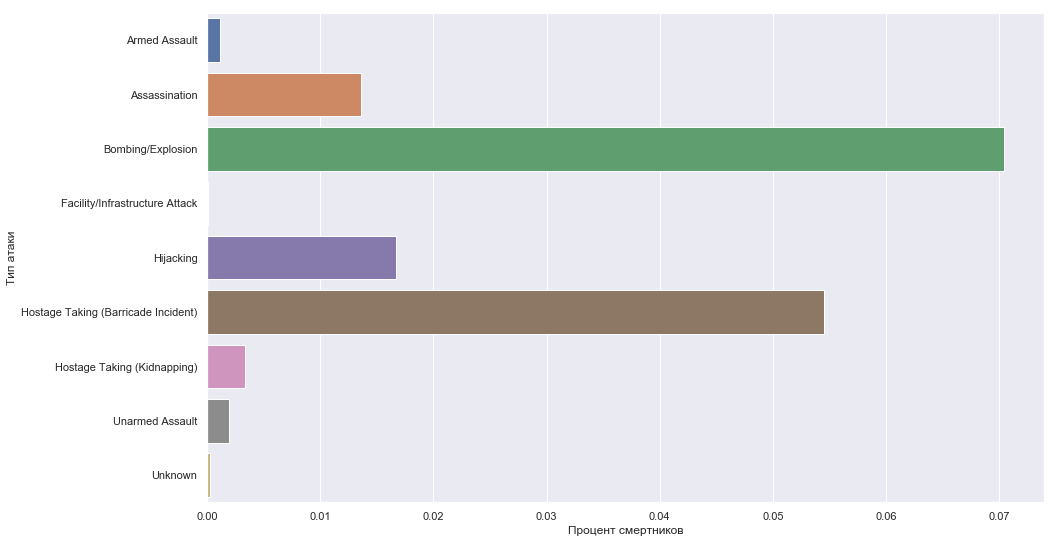

In [137]:
sns.set(rc={'figure.figsize':(15,9)})

pl = sns.barplot(x='prop', y='attacktype1_txt', data=data_attacktype_suicide)
pl.set_ylabel('Тип атаки')
pl.set_xlabel('Процент смертников')

*Выводы*

- Общее количество смертников мало относительно всего массива данных
- Смертники предпочитают бомбы и захват заложников

###### Крупнейшие террористические акты

In [138]:
# Выбыерем 100 крупнейших террактов
data_terr = data[['city', 'country_txt', 'latitude', 'longitude', 'nkill']].sort_values(['nkill'], ascending=False)
data_terr.columns = ['City', 'Country', 'Latitude', 'Longitude', 'nkill']
data_terr = data_terr[(data_terr['City'] != 'Unknown') & (data_terr['Latitude'].notnull())].iloc[:100]
data_terr.head()

,City,Country,Latitude,Longitude,nkill
2014-06-12,Tikrit,Iraq,34.621521,43.668377,1570.0
2001-09-11,New York City,United States,40.697132,-73.931351,1384.0
2001-09-11,New York City,United States,40.697132,-73.931351,1383.0
1994-04-13,Gikoro,Rwanda,-1.932787,30.332456,1180.0
2014-08-03,Sinjar,Iraq,36.319386,41.861473,953.0


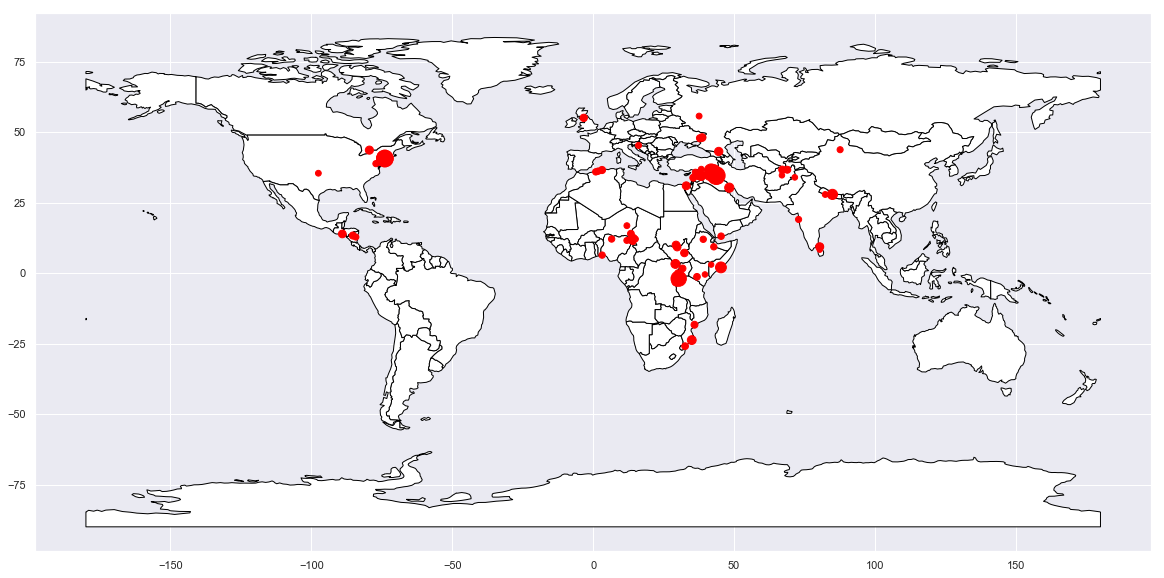

In [139]:
# Задаим параметры для карты
#fig, ax = plt.subplots()

gdf = geopandas.GeoDataFrame(data_terr, geometry=geopandas.points_from_xy(data_terr.Longitude, data_terr.Latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Нарисуем распределение на карте
ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
a  = gdf.plot(ax=ax, markersize = data_terr['nkill'] / 5, marker='o', color='red', cax='right')

*Выоводы*

- Большая часть крупнейших террористических актов сосредоточена на Африканском континенте


###### Террористические группировки и их методы атак

In [216]:
data_group = data[['gname', 'attacktype1_txt', 'eventid']]
data_group = data_group[data_group['gname'] != 'Unknown']
data_group = data_group[data_group['attacktype1_txt'] != 'Unknown']
data_group = data_group.groupby(['gname', 'attacktype1_txt']).agg({'eventid':len})
data_group_terr = data_group.groupby(level=0).agg({'eventid':sum})
data_group_type_att = data_group.groupby(level=0).apply(lambda x: x.idxmax()).applymap(lambda x: x[1])

data_group_top = data_group_terr.merge(data_group_type_att, left_index=True, right_index=True).reset_index().sort_values(['eventid_x'], ascending=False).iloc[:10]

[Text(17.19999999999999, 0.5, 'Топ. тип атаки'),
 Text(0.5, 17.246875000000003, 'Общее количество террактов')]

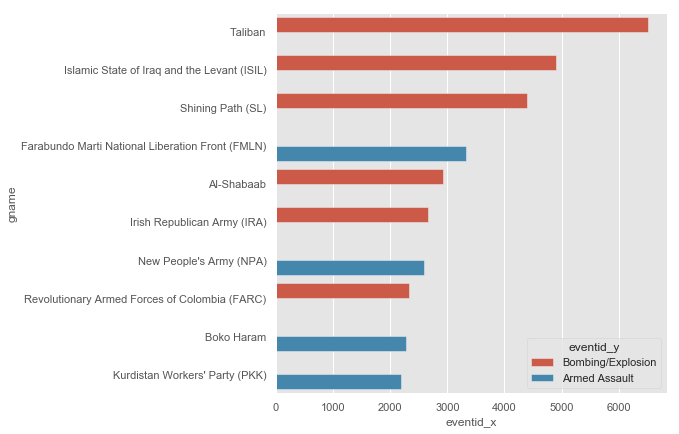

In [239]:
sns.set(rc={'figure.figsize':(7,7)})
plt.style.use('ggplot')

sns.barplot(data=data_group_top, y='gname',x='eventid_x', hue='eventid_y')
gp.set(ylabel='Топ. тип атаки', xlabel='Общее количество террактов')

*Общие выводы из полученных данных*

- Наибольшей активности терроризм как тактика ведения боевых действий приобрел после 2000 года
- Основные районы действий террористов делятся на 2 лагеря
 - до 2000-х годов это в основном леворадикальные(или сепаратистские) группировки действующие на территории латинской америки и европы
 - после 2000-х годов это в основнм терроризм в азии, африке и ближнем востоке
- Наиболее безопасная страна это Монголия, наиболее опасная это Ирак (также Пакистан и Индия)
- Чаще всего террористы закладывают бомбы и атакуют военных
- Среди всех террактов смертников довольно маленькое количество
- Большая часть самых кровавых терриристических актов происходила на территории Африки
- Самые активные террористические группировки Талибан и Игил, самые активные не исламские группировки ИРА и ФНОФМ